In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

**Load The Data**

In [ ]:
current_dir = os.getcwd()
relative_path = os.path.join('..','..', 'data', 'x_train.csv')
x_train=pd.read_csv(os.path.join(current_dir, relative_path))
relative_path = os.path.join('..','..', 'data', 'y_train.csv')
y_train=pd.read_csv(os.path.join(current_dir, relative_path))

relative_path = os.path.join('..','..', 'data', 'x_val.csv')
x_val=pd.read_csv(os.path.join(current_dir, relative_path))
relative_path = os.path.join('..','..', 'data', 'y_val.csv')
y_val=pd.read_csv(os.path.join(current_dir, relative_path))

relative_path = os.path.join('..','..', 'data', 'x_test.csv')
x_test=pd.read_csv(os.path.join(current_dir, relative_path))
relative_path = os.path.join('..','..', 'data', 'y_test.csv')
y_test=pd.read_csv(os.path.join(current_dir, relative_path))

relative_path = os.path.join('..','..', 'data', 'x_train_smote.csv')
x_train_smote=pd.read_csv(os.path.join(current_dir, relative_path))
relative_path = os.path.join('..','..', 'data', 'y_train_smote.csv')
y_train_smote=pd.read_csv(os.path.join(current_dir, relative_path))

relative_path = os.path.join('..','..', 'data', 'x_train_ros.csv')
x_train_ros=pd.read_csv(os.path.join(current_dir, relative_path))
relative_path = os.path.join('..','..', 'data', 'y_train_ros.csv')
y_train_ros=pd.read_csv(os.path.join(current_dir, relative_path))

relative_path = os.path.join('..','..', 'data', 'x_train_rur.csv')
x_train_rur=pd.read_csv(os.path.join(current_dir, relative_path))
relative_path = os.path.join('..','..', 'data', 'y_train_rur.csv')
y_train_rur=pd.read_csv(os.path.join(current_dir, relative_path))

relative_path = os.path.join('..','..', 'data', 'x_train_smotetomek.csv')
x_train_smotetomek=pd.read_csv(os.path.join(current_dir, relative_path))
relative_path = os.path.join('..','..', 'data', 'y_train_smotetomek.csv')
y_train_smotetomek=pd.read_csv(os.path.join(current_dir, relative_path))

In [2]:
# Colab Path
x_train=pd.read_csv('x_train.csv')
y_train=pd.read_csv('y_train.csv')

x_val=pd.read_csv('x_val.csv')
y_val=pd.read_csv('y_val.csv')

x_test=pd.read_csv('x_test.csv')
y_test=pd.read_csv('y_test.csv')

**AdaBoost**

without resampling

In [3]:
# Define the parameter grid for grid search
param_grid = {
    'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2),
                       DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=4),
                       DecisionTreeClassifier(max_depth=5)],
    'n_estimators': [10, 20, 50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0]
}

# Initialize AdaBoostClassifier
ada_clf = AdaBoostClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator=ada_clf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Get the best model
best_ada_clf = grid_search.best_estimator_

# Get the best parameters
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarnin

Best Parameters: {'base_estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 0.5, 'n_estimators': 50}


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [6]:
base_estimator = best_params['base_estimator']
n_estimators = best_params['n_estimators']
learning_rate = best_params['learning_rate']
print(f'Best base_estimator: {base_estimator}')
print(f'Best n_estimators: {n_estimators}')
print(f'Best learning_rate: {learning_rate}')

Best base_estimator: DecisionTreeClassifier(max_depth=1)
Best n_estimators: 50
Best learning_rate: 0.5


In [17]:
# Predict on the training set
y_train_pred = best_ada_clf.predict(x_train)

# Calculate training accuracy (in-sample error)
training_accuracy = accuracy_score(y_train, y_train_pred)

print("Training Accuracy:", training_accuracy)

Training Accuracy: 0.8819148936170212


In [7]:
# Evaluate the best model on validation data
val_accuracy = best_ada_clf.score(x_val, y_val)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.8771186440677966


In [15]:
# Perform k-fold cross-validation (with 5 folds)
scores = cross_val_score(ada_clf, x_train, y_train, cv=5)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [16]:
# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

Cross-validation scores: [0.83510638 0.83510638 0.86702128 0.83510638 0.88829787]
Mean cross-validation score: 0.852127659574468


In [8]:
# Predict on validation set
y_val_pred = best_ada_clf.predict(x_val)

# Calculate precision, recall, and F1-score
report = classification_report(y_val, y_val_pred, target_names=['Class 0', 'Class 1'])

# Print the classification report
print("Classification Report for Validation Set:")
print(report)

Classification Report for Validation Set:
              precision    recall  f1-score   support

     Class 0       0.87      1.00      0.93       191
     Class 1       1.00      0.36      0.52        45

    accuracy                           0.88       236
   macro avg       0.93      0.68      0.73       236
weighted avg       0.89      0.88      0.85       236



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarnin

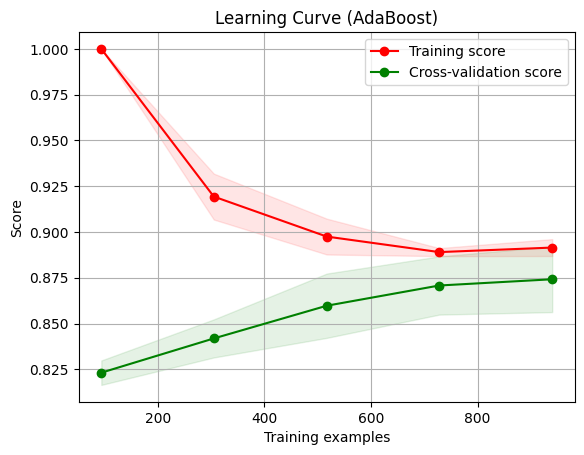

In [23]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

X = np.concatenate((x_train, x_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)

# Plot learning curve
plot_learning_curve(best_ada_clf, "Learning Curve (AdaBoost)", X, y, cv=5)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarnin

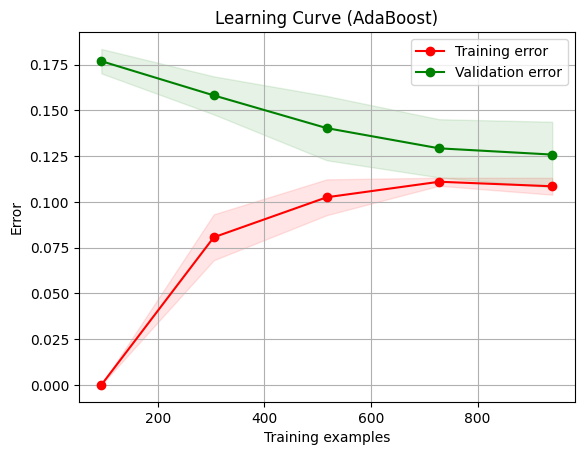

In [24]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the training and validation learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    train_errors_mean = -np.mean(train_scores, axis=1)
    train_errors_std = np.std(train_scores, axis=1)
    test_errors_mean = -np.mean(test_scores, axis=1)
    test_errors_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_errors_mean - train_errors_std,
                     train_errors_mean + train_errors_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_errors_mean - test_errors_std,
                     test_errors_mean + test_errors_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_errors_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_errors_mean, 'o-', color="g",
             label="Validation error")

    plt.legend(loc="best")
    return plt

X = np.concatenate((x_train, x_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)

# Plot learning curve
plot_learning_curve(best_ada_clf, "Learning Curve (AdaBoost)", X, y, cv=5)
plt.show()

In [ ]:
'''
The decreasing training score suggests that as more training examples are provided, the model is exposed to a wider variety of instances and is learning to generalize better.
This is a positive sign as it indicates that the model is not memorizing the training data but rather learning meaningful patterns.

The increasing validation score indicates that the model's performance on unseen data is improving as more training examples are provided.
This suggests that the model is generalizing well to new instances and is not overfitting to the training data.

The small gap between the training and validation scores suggests that the model is not suffering from significant overfitting.
The fact that both scores are increasing with a small gap indicates that the model is learning to generalize well to unseen data without excessively fitting to the training data.

The fact that both the training and validation scores are eventually increasing slowly that the model's performance is stabilizing as more data is provided.
This is a desirable outcome, indicating that additional data may not significantly improve the model's performance further.

'''

SMOTE

RandomOverSampler

SMOTETomek

RandomUnderSampler